# 1000Á∂≠ 10000Á≠ÜË≥áÊñôË∑ëÁµ±Ë®àÊ™¢ÂÆö

1000Á∂≠Â∏∏ÊÖãÂàÜ‰Ωà ‰∏ÄËê¨Á≠ÜË≥áÊñôË∑ëÊ™¢ÂÆö Âõ†ÁÇ∫ÊúÄÂæåË¶ÅÁúãnmist Ë¶ÅÂ§öÁ∂≠ÔºåÁúãÁµ±Ë®àÊ™¢ÂÆöÂèØ‰∏çÂèØ‰ª•ÈÅé  
=> ÊàñÊòØÁõ¥Êé•‰∏ãËºâmnistË≥áÊñôÂàÜÂÖ©ÂçäÁúãÊØçÈ´îÊòØ‰∏çÊòØ‰∏ÄÊ®£ÁöÑ


ÂÖ©ÂÄãÊñπÊ°àÔºö
* A) ‰∫∫Â∑•Áî¢ÁîüÁöÑ 1000 Á∂≠Â∏∏ÊÖã„ÄÅ1 Ëê¨Á≠Ü
* B) Áõ¥Êé•Áî® MNIST ÂàÜÂÖ©ÂçäÊØî„ÄåÊòØÂê¶ÂêåÊØçÈ´î„Äç„ÄÇ

ËÄå‰∏äËø∞ÊñπÊ°àÈÉΩÂåÖÂê´Ôºö
* **Energy distance(ÁΩÆÊèõÊ™¢ÂÆö)**
* **MMD(Ê†∏ÂÖ©Ê®£Êú¨)**
* **Hotelling‚Äôs ÔºàÁî®Á∏ÆÊ∏õÂÖ±ËÆäÊï∏ÈÅøÂÖçÈ´òÁ∂≠‰∏çÁ©©Ôºâ**
* ÂÜçÂä†**ÈÄêÁ∂≠ t-test + FDRËàáPCA Ë¶ñË¶∫Âåñ**„ÄÇ

---

## 10/22 ‰ªªÂãô
Áî®nmist datasetÁöÑ0, 1ÂΩ±ÂÉè  
Â§öÁ∂≠Â§öË≥áÊñôË∑ëÁµ±Ë®à => È†êÊ∏¨pÊáâË©≤Ë¶ÅÈÅ†Â∞èÊñº0.05(Âõ†ÁÇ∫ÊòØ‰∏çÂêåÁöÑdataset)

## Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.covariance import LedoitWolf
from sklearn.metrics.pairwise import rbf_kernel

rng = np.random.default_rng(0)

def energy_stat(X, Y):
    # Ë´ñÊñáÂÆöÁæ©ÁöÑÂÖ©Ê®£Êú¨ energy distance ÁöÑ„ÄåÁµ±Ë®àÈáè„Äç(Êú™Ê®ôÊ∫ñÂåñÂ∏∏Êï∏Â∞çp-value‰∏çÂΩ±Èüø)
    # E||X - Y|| - 0.5 E||X - X'|| - 0.5 E||Y - Y'||
    def _avg_pairwise_norm(A, B):
        # Âπ≥Âùá L2 Ë∑ùÈõ¢
        a2 = np.sum(A*A, axis=1)[:,None]
        b2 = np.sum(B*B, axis=1)[None,:]
        D2 = a2 + b2 - 2*A@B.T
        np.maximum(D2, 0, out=D2)
        return np.mean(np.sqrt(D2))
    return _avg_pairwise_norm(X, Y) - 0.5*_avg_pairwise_norm(X, X) - 0.5*_avg_pairwise_norm(Y, Y)

def permutation_test(stat_fn, X, Y, n_perm=500, tail='right', subsample=None):
    # ÂèØÈÅ∏Êìá‰∏ãÊé°Ê®£Âä†ÈÄü
    if subsample is not None:
        nX = min(len(X), subsample//2)
        nY = min(len(Y), subsample - nX)
        X = X[rng.choice(len(X), nX, replace=False)]
        Y = Y[rng.choice(len(Y), nY, replace=False)]
    z = np.vstack([X, Y])
    n, m = len(X), len(Y)
    stat_obs = stat_fn(X, Y)
    cnt = 0
    for _ in range(n_perm):
        idx = rng.permutation(len(z))
        Xp, Yp = z[idx[:n]], z[idx[n:]]
        s = stat_fn(Xp, Yp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:  # two-sided
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval

def mmd_stat(X, Y, gamma='median'):
    Z = np.vstack([X, Y])
    if gamma == 'median':
        # median heuristic
        idx = rng.choice(len(Z), size=min(2000, len(Z)), replace=False)
        Zs = Z[idx]
        d2 = np.sum((Zs[:,None,:]-Zs[None,:,:])**2, axis=2)
        med = np.median(d2[np.triu_indices_from(d2, 1)])
        gamma = 1.0 / (med + 1e-12)
    Kxx = rbf_kernel(X, X, gamma=gamma)
    Kyy = rbf_kernel(Y, Y, gamma=gamma)
    Kxy = rbf_kernel(X, Y, gamma=gamma)
    # u-statistic MMD^2
    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)
    m, n = len(X), len(Y)
    return Kxx.sum()/(m*(m-1)) + Kyy.sum()/(n*(n-1)) - 2*Kxy.mean()

def hotellings_T2_two_sample(X, Y):
    # ÂÖ©Ê®£Êú¨ Hotelling‚Äôs T^2 ÔºàÂùáÂÄºÊòØÂê¶Áõ∏Á≠âÔºâ„ÄÅÂÖ±ËÆäÊï∏Áî® Ledoit-Wolf Á∏ÆÊ∏õÔºåÁ©©ÂÆöÈ´òÁ∂≠
    n, m = len(X), len(Y)
    p = X.shape[1]
    mx, my = X.mean(axis=0), Y.mean(axis=0)
    # pooled covariance estimate via shrinkage
    Sx = LedoitWolf().fit(X - mx).covariance_
    Sy = LedoitWolf().fit(Y - my).covariance_
    Sp = ((n-1)*Sx + (m-1)*Sy) / (n+m-2)
    # T^2
    diff = (mx - my)
    # Êï∏ÂÄºÁ©©ÂÆöÁöÑÈÄÜ
    from numpy.linalg import solve
    T2 = (n*m/(n+m)) * diff @ solve(Sp, diff)
    # ËΩâÊàê F ÂàÜ‰Ωà
    # F = ((n+m-p-1)/(p*(n+m-2))) * T2 ~ F_{p, n+m-p-1}
    df1 = p
    df2 = n + m - p - 1
    if df2 <= 0:
        return T2, np.nan, (df1, df2)
    Fstat = ((n+m-p-1)/(p*(n+m-2))) * T2
    pval = 1 - f.cdf(Fstat, df1, df2)
    return T2, pval, (df1, df2)

def per_dim_tests_with_fdr(X, Y):
    pvals = np.array([ttest_ind(X[:,i], Y[:,i], equal_var=False).pvalue
                      for i in range(X.shape[1])])
    rej, pvals_fdr, _, _ = multipletests(pvals, method='fdr_bh')
    return pvals, pvals_fdr, rej

def quick_pca_plot(X, Y, title='PCA'):
    Z = np.vstack([X, Y])
    labels = np.array([0]*len(X) + [1]*len(Y))
    Z2 = PCA(n_components=2, random_state=0).fit_transform(Z)
    plt.figure(figsize=(5,4))
    plt.scatter(Z2[labels==0,0], Z2[labels==0,1], s=8, alpha=0.8, label='Group X')
    plt.scatter(Z2[labels==1,0], Z2[labels==1,1], s=8, alpha=0.8, label='Group Y')
    plt.title(title); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend(); plt.show()


In [2]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

# ---------- Â∑•ÂÖ∑Ôºö‰∏ÄÊ¨°ÊÄßÂª∫Á´ãË∑ùÈõ¢ / Ê†∏Áü©Èô£ ----------
def pairwise_l2_dist(Z, dtype=np.float32):
    """
    Z: (N, d)  ‚Üí ÂõûÂÇ≥ D: (N, N)ÔºåD[i,j] = ||Z[i]-Z[j]||_2
    Ë®ªÔºöË®òÊÜ∂È´îËÄÉÈáèÔºåfloat32 Âç≥ÂèØÔºõN=4000 ÊôÇ ~61MB„ÄÇ
    """
    Z = Z.astype(dtype, copy=False)
    nrm = np.sum(Z*Z, axis=1, dtype=np.float64)  # Áî® float64 ÈôçË™§Â∑Æ
    D2 = nrm[:,None] + nrm[None,:] - 2.0 * (Z @ Z.T).astype(np.float64, copy=False)
    np.maximum(D2, 0.0, out=D2)
    D = np.sqrt(D2, dtype=np.float64).astype(dtype, copy=False)
    return D

def rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, max_med_samples=2000, rng=None):
    """
    ÂõûÂÇ≥ K: (N,N) ÁöÑ RBF Gram Áü©Èô£Ôºõgamma ÂèØÁî® median heuristic Ëá™Âãï‰º∞„ÄÇ
    """
    if gamma == 'median':
        N = len(Z)
        rng = np.random.default_rng(None) if rng is None else rng
        idx = rng.choice(N, size=min(max_med_samples, N), replace=False)
        Zs = Z[idx]
        # ‰ª•Ê≠êÂºèË∑ùÈõ¢Âπ≥ÊñπÁöÑ‰∏≠‰ΩçÊï∏ÂÅö heuristic
        nrm = np.sum(Zs*Zs, axis=1, dtype=np.float64)
        d2 = nrm[:,None] + nrm[None,:] - 2.0 * (Zs @ Zs.T).astype(np.float64, copy=False)
        med = np.median(d2[np.triu_indices_from(d2, 1)])
        gamma = 1.0 / (med + 1e-12)
    K = rbf_kernel(Z, Z, gamma=float(gamma)).astype(dtype, copy=False)
    return K, gamma

# ---------- EnergyÔºöÂæûË∑ùÈõ¢Áü©Èô£Êì∑ÂèñÁµ±Ë®àÈáè ----------
def energy_from_D(D, A_idx, B_idx):
    """
    Ëàá‰Ω†ÂÖàÂâçÁöÑ energy_stat ‰∏ÄËá¥Ôºö‰ΩøÁî®„ÄåÂê´Â∞çËßí„ÄçÁöÑÂπ≥ÂùáË∑ùÈõ¢Ôºàpermutation ‰∏ã‰∏çÂΩ±ÈüøÊúâÊïàÊÄßÔºâ
    E||X-Y|| - 0.5 E||X-X'|| - 0.5 E||Y-Y'||
    """
    AA = D[np.ix_(A_idx, A_idx)]
    BB = D[np.ix_(B_idx, B_idx)]
    AB = D[np.ix_(A_idx, B_idx)]
    return AB.mean() - 0.5*AA.mean() - 0.5*BB.mean()

def permutation_energy_precomputed(D, nA, n_perm=300, tail='right', rng=None):
    """
    D: (N,N) Ë∑ùÈõ¢Áü©Èô£ÔºàÊï¥È´îË≥áÊñô Z ÁöÑ pairwise L2Ôºâ
    nA: A ÁöÑÊ®£Êú¨Êï∏ÔºàÂâç nA Â±¨ AÔºåÂÖ∂È§òÂ±¨ BÔºõÂè™‰ΩúÁÇ∫ËßÄÂØüÂÄºÁöÑÂàáÊ≥ïÔºâ
    """
    N = D.shape[0]
    all_idx = np.arange(N)
    A = all_idx[:nA]
    B = all_idx[nA:]
    stat_obs = energy_from_D(D, A, B)

    rng = np.random.default_rng(None) if rng is None else rng
    cnt = 0
    for _ in range(n_perm):
        perm = rng.permutation(N)
        Ap = perm[:nA]
        Bp = perm[nA:]
        s = energy_from_D(D, Ap, Bp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval

# ---------- MMDÔºöÂæû Gram Áü©Èô£Êì∑Âèñ U-statistic ----------
def mmd_u_from_K(K, A_idx, B_idx):
    """
    U-statistic ÁâàÊú¨ÔºàÂ∞çËßíÊéíÈô§ÔºâÔºõÂÅáË®≠ K ÁöÑÂ∞çËßíÁ∑öÂèØÁÇ∫‰ªªÊÑèÂÄºÔºåÊàëÂÄëÊâãÂãïÊéíÈô§Â∞çËßí„ÄÇ
    """
    Ka = K[np.ix_(A_idx, A_idx)]
    Kb = K[np.ix_(B_idx, B_idx)]
    Kab = K[np.ix_(A_idx, B_idx)]
    m, n = Ka.shape[0], Kb.shape[0]
    # ÊéíÈô§Â∞çËßí
    sum_Ka = (Ka.sum() - np.trace(Ka)) / (m*(m-1) + 1e-12)
    sum_Kb = (Kb.sum() - np.trace(Kb)) / (n*(n-1) + 1e-12)
    sum_Kab = Kab.mean()
    return sum_Ka + sum_Kb - 2.0*sum_Kab

def permutation_mmd_precomputed(K, nA, n_perm=300, tail='right', rng=None):
    """
    K: (N,N) RBF Gram Áü©Èô£
    nA: A ÁöÑÊ®£Êú¨Êï∏
    """
    N = K.shape[0]
    all_idx = np.arange(N)
    A = all_idx[:nA]
    B = all_idx[nA:]
    stat_obs = mmd_u_from_K(K, A, B)

    rng = np.random.default_rng(None)
    if rng is None:
        rng = np.random.default_rng(None)

    cnt = 0
    for _ in range(n_perm):
        perm = rng.permutation(N)
        Ap = perm[:nA]
        Bp = perm[nA:]
        s = mmd_u_from_K(K, Ap, Bp)
        if tail == 'right':
            cnt += (s >= stat_obs)
        elif tail == 'left':
            cnt += (s <= stat_obs)
        else:
            cnt += (abs(s) >= abs(stat_obs))
    pval = (cnt + 1) / (n_perm + 1)
    return stat_obs, pval


---

## Case A: 1000 Á∂≠Â∏∏ÊÖã„ÄÅÂêÑ 5000 Á≠ÜÔºàÁ∏Ω 1 Ëê¨Ôºâ

(MMD uses gamma=5.011e-04)
[Energy] stat=0.0223, p‚âà0.5482
[MMD]    stat=-0.0000, p‚âà0.5515
[T^2]    T2=959.08, p‚âà0.9988406598740156, df=(1000, 8999)
[FDR]    significant dims = 0 / 1000


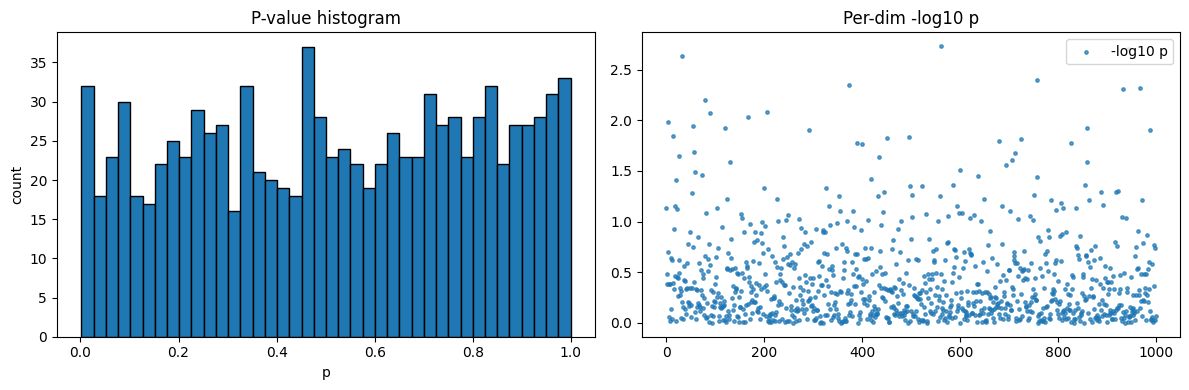

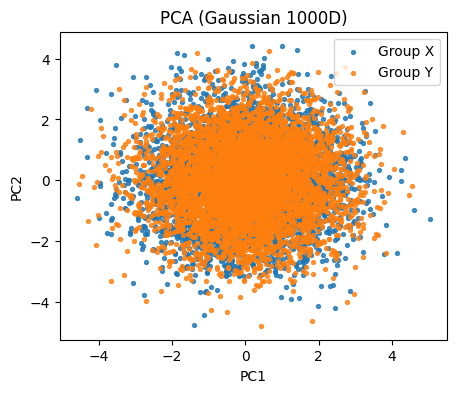

In [3]:
d = 1000
n1 = n2 = 5000

# ÊØçÈ´î‰∏ÄÊ®£ÔºàËôõÁÑ°Ôºâ‚Üí ÂèØÊîπÊàê shift[:30]=0.15 ‰ΩúÁÇ∫ÊúâÂ∑ÆÁï∞ÁöÑÊÉÖÂ¢É
mu1 = np.zeros(d)
mu2 = np.zeros(d)

# ‰πüÂèØÂÅöÂá∫Áõ∏ÈóúÊÄßÔºöÈÄôË£°ÂÖàÁî®Áç®Á´ãÂ∏∏ÊÖã
X = rng.standard_normal((n1, d)) + mu1
Y = rng.standard_normal((n2, d)) + mu2

# ---- Ê™¢ÂÆöÂÄë ----
# === Case A Âä†ÈÄüÁâàÔºöÂÖà‰∏ãÊé°Ê®£„ÄÅÂÜç‰∏ÄÊ¨°ÊÄßÂª∫Á´ãÁü©Èô£ÔºåÁΩÆÊèõÂè™ÂÅöÁ¥¢Âºï ===
rng = np.random.default_rng(0)
subsample = 4000   # ÊÉ≥Êõ¥Âø´ÂèØÈôçÂà∞ 2000
nA = min(len(X), subsample//2)
nB = min(len(Y), subsample - nA)
Xa = X[rng.choice(len(X), nA, replace=False)]
Yb = Y[rng.choice(len(Y), nB, replace=False)]
Z  = np.vstack([Xa, Yb])

# EnergyÔºàÈ†êÂÖàÁÆóË∑ùÈõ¢Áü©Èô£Ôºâ
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=nA, n_perm=300, tail='right', rng=rng)

# MMDÔºàÈ†êÂÖàÁÆó RBF GramÔºâ
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=nA, n_perm=300, tail='right', rng=rng)
print(f"(MMD uses gamma={gamma:.3e})")


# 3) Hotelling‚Äôs T^2ÔºàÁî® Ledoit-Wolf Á∏ÆÊ∏õÂÖ±ËÆäÊï∏Ôºâ
T2, T2_p, dfs = hotellings_T2_two_sample(X, Y)

# 4) ÈÄêÁ∂≠ + FDR
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(X, Y)

print(f"[Energy] stat={estat:.4f}, p‚âà{ep:.4g}")
print(f"[MMD]    stat={mmd:.4f}, p‚âà{mmd_p:.4g}")
print(f"[T^2]    T2={T2:.2f}, p‚âà{T2_p}, df={dfs}")
print(f"[FDR]    significant dims = {rej.sum()} / {d}")

# Ë¶ñË¶∫Âåñ
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black'); plt.title('P-value histogram'); plt.xlabel('p'); plt.ylabel('count')
plt.subplot(1,2,2)
plt.scatter(range(d), neglogp, s=6, alpha=0.7, label='-log10 p')
if rej.any():
    plt.scatter(np.where(rej)[0], neglogp[rej], s=8, alpha=0.9, label='FDR sig')
plt.title('Per-dim -log10 p'); plt.legend(); plt.tight_layout(); plt.show()

quick_pca_plot(X, Y, title='PCA (Gaussian 1000D)')


ÁêÜË´ñ‰∏äÂèØ‰ª•‰Ωú‰ΩÜÊôÇÈñìÂ§™‰πÖ‰∫Ü, Âõ†ÁÇ∫permutation test:
> Case A Ë£°ÊúÄËä±ÊôÇÈñìÁöÑÊòØ„ÄåÁΩÆÊèõÊ™¢ÂÆöÔºàpermutationÔºâ√ó È´òÁ∂≠ÊàêÂ∞çË∑ùÈõ¢/Ê†∏Áü©Èô£„Äç„ÄÇ‰Ω†Ë®≠ n_perm=300„ÄÅsubsample=4000ÔºåÊØèÊ¨°ÈÉΩË¶ÅÁÆó ~2000√ó2000 ÁöÑË∑ùÈõ¢/Ê†∏ÔºåÂÜçÈáçË§á 300 Ê¨°ÔºåË∑ëÂÄã 2‚Äì3 ÂàÜÈêòÂæàÊ≠£Â∏∏ÔºàCPU„ÄÅBLAS„ÄÅË®òÊÜ∂È´îÈ†ªÂØ¨ÈÉΩÊúÉÂΩ±ÈüøÔºâ„ÄÇ

---

## Case B: MNISTÔºö‰∏ãËºâ„ÄÅÂàÜÂÖ©ÂçäÔºåÊ™¢ÂÆö„ÄåÊòØÂê¶ÂêåÊØçÈ´î„Äç

[MNIST Energy-fast] stat=0.0031, p‚âà0.6468
[MNIST MMD-fast]    stat=-0.0000, p‚âà0.6667 (gamma=9.524e-03)
[MNIST T^2]    T2=5.79e+02, p‚âà0.9999999979593517, df=(784, 69215)
[MNIST FDR]    sig dims=0 / 784


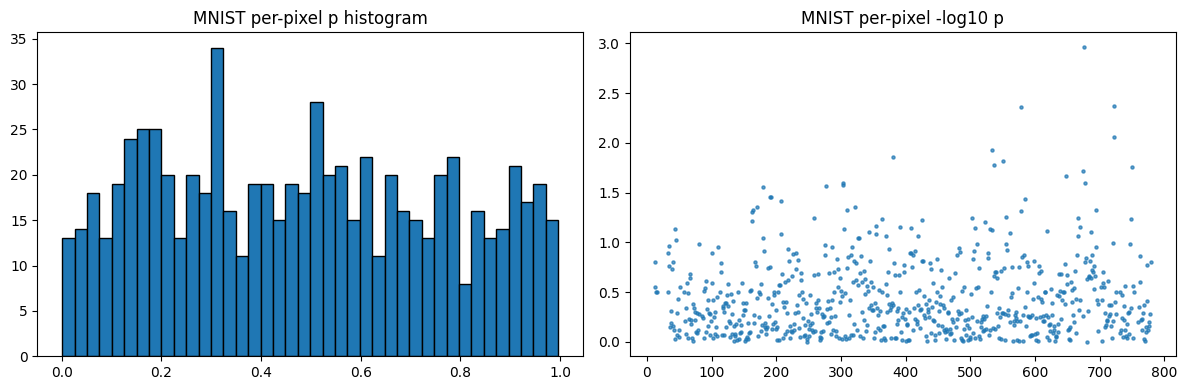

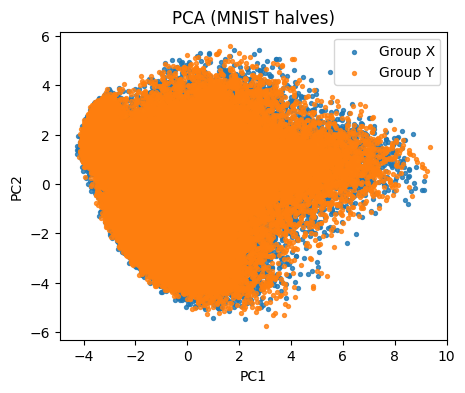

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# ‰∏ãËºâ MNIST (784 Á∂≠ÂÉèÁ¥†)
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
Xall = mnist.data.astype(np.float32)  # shape (70000, 784)
yall = mnist.target.astype(int)

# Â∏∏Ë¶ãÂâçËôïÁêÜÔºöÊ®ôÊ∫ñÂåñÂÉèÁ¥†Âà∞ 0-1 ÊàñÊ®ôÊ∫ñÂåñÂà∞Èõ∂ÂùáÂÄºÂñÆ‰ΩçÊñπÂ∑ÆÔºå‰∫åÊìá‰∏Ä
Xall = Xall / 255.0
# ÊàñÔºöXall = StandardScaler().fit_transform(Xall)

# ÂàÜÂÖ©ÂçäÔºàÈö®Ê©üÊ¥óÁâåÂæåÂàáÔºâ
rng = np.random.default_rng(0)
idx = rng.permutation(len(Xall))
A = Xall[idx[:35000]]
B = Xall[idx[35000:]]

# === Case B: MNIST Âä†ÈÄüÁâà Energy / MMD Ê™¢ÂÆö ===
# Âèñ‰∏ãÊé°Ê®£ÔºàÈÅøÂÖç 35000√ó35000 ÁàÜË®òÊÜ∂È´îÔºâ
subsample = 6000
nA = min(len(A), subsample // 2)
nB = min(len(B), subsample - nA)
Aa = A[rng.choice(len(A), nA, replace=False)]
Bb = B[rng.choice(len(B), nB, replace=False)]
Z  = np.vstack([Aa, Bb])

# ---- EnergyÔºàÈ†êÂÖàÁÆóË∑ùÈõ¢Áü©Èô£Ôºâ----
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=nA, n_perm=200, tail='right', rng=rng)

# ---- MMDÔºàÈ†êÂÖàÁÆó RBF GramÔºâ----
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=nA, n_perm=200, tail='right', rng=rng)
print(f"[MNIST Energy-fast] stat={estat:.4f}, p‚âà{ep:.4g}")
print(f"[MNIST MMD-fast]    stat={mmd:.4f}, p‚âà{mmd_p:.4g} (gamma={gamma:.3e})")

# ---- ÂÖ∂‰ªñÊ™¢ÂÆöÔºà‰øùÊåÅÂéüÊ®£Ôºâ----
T2, T2_p, dfs = hotellings_T2_two_sample(A, B)
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(A, B)

print(f"[MNIST T^2]    T2={T2:.2e}, p‚âà{T2_p}, df={dfs}")
print(f"[MNIST FDR]    sig dims={rej.sum()} / {A.shape[1]}")

# ---- Ë¶ñË¶∫Âåñ ----
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black')
plt.title('MNIST per-pixel p histogram')
plt.subplot(1,2,2)
plt.scatter(range(A.shape[1]), neglogp, s=5, alpha=0.7)
plt.title('MNIST per-pixel -log10 p')
plt.tight_layout()
plt.show()

quick_pca_plot(A, B, title='PCA (MNIST halves)')


---

# 10/22 Êñ∞Â¢û
* ÊØîËºÉË≥áÊñôÔºö0,1 ÂΩ±ÂÉè(from Mnist)  
* Êï∏ÈáèÔºö6500
* Á∂≠Â∫¶Ôºö784
* Áµ±Ë®àÊñπÊ≥ïÔºö
  * Energy
  * MMD
  * Hotelling‚Äôs T¬≤
  * FDR + PCA

Class 0: 6903 samples, Class 1: 7877 samples
[MNIST 0 vs 1 | Energy-fast] stat=3.2040, p‚âà0.004975
[MNIST 0 vs 1 | MMD-fast]    stat=0.4742, p‚âà0.004975 (gamma=9.429e-03)
[Hotelling‚Äôs T¬≤]  T2=4.36e+05, p‚âà1.11e-16, df=(784, 12215)
[FDR]             sig dims=452 / 784


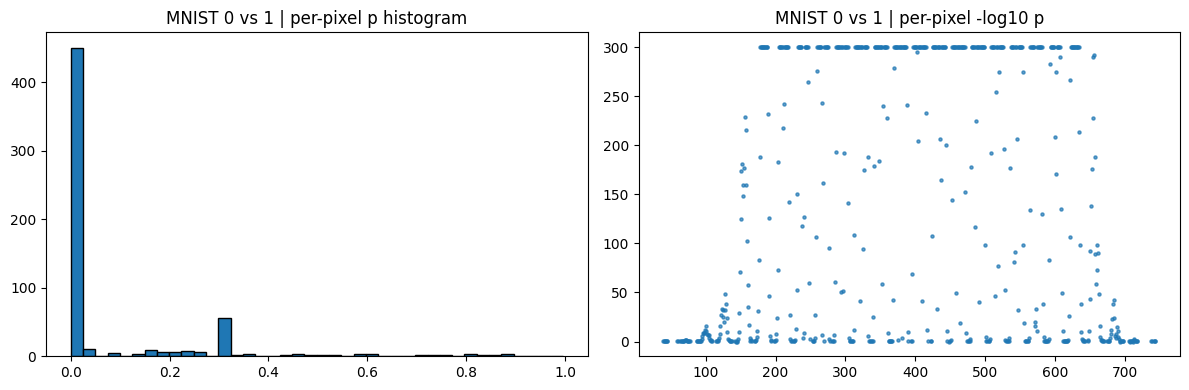

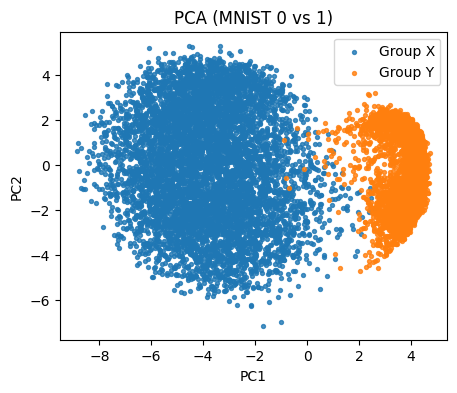

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# ËºâÂÖ• MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
Xall = mnist.data.astype(np.float32) / 255.0
yall = mnist.target.astype(int)

# ÊäΩÂá∫Êï∏Â≠ó 0 Ëàá 1
X0 = Xall[yall == 0]
X1 = Xall[yall == 1]
print(f"Class 0: {len(X0)} samples, Class 1: {len(X1)} samples")

# ÁÇ∫‰∫ÜËàá case B Â∞∫Â∫¶Áõ∏‰ººÔºåÈö®Ê©üÂèñÊ®£ÂêÑ 6500 Á≠Ü
rng = np.random.default_rng(0)
nA = nB = 6500
A = X0[rng.choice(len(X0), nA, replace=False)]
B = X1[rng.choice(len(X1), nB, replace=False)]

# ---- Âä†ÈÄüÁâà Energy / MMD ----
subsample = 4000
na = min(len(A), subsample // 2)
nb = min(len(B), subsample - na)
Aa = A[rng.choice(len(A), na, replace=False)]
Bb = B[rng.choice(len(B), nb, replace=False)]
Z  = np.vstack([Aa, Bb])

# Energy distance
D = pairwise_l2_dist(Z, dtype=np.float32)
estat, ep = permutation_energy_precomputed(D, nA=na, n_perm=200, tail='right', rng=rng)

# MMD
K, gamma = rbf_gram_precomputed(Z, gamma='median', dtype=np.float32, rng=rng)
mmd, mmd_p = permutation_mmd_precomputed(K, nA=na, n_perm=200, tail='right', rng=rng)
print(f"[MNIST 0 vs 1 | Energy-fast] stat={estat:.4f}, p‚âà{ep:.4g}")
print(f"[MNIST 0 vs 1 | MMD-fast]    stat={mmd:.4f}, p‚âà{mmd_p:.4g} (gamma={gamma:.3e})")

# ---- Hotelling‚Äôs T¬≤ + FDR ----
T2, T2_p, dfs = hotellings_T2_two_sample(A, B)
pvals, pvals_fdr, rej = per_dim_tests_with_fdr(A, B)

print(f"[Hotelling‚Äôs T¬≤]  T2={T2:.2e}, p‚âà{T2_p:.4g}, df={dfs}")
print(f"[FDR]             sig dims={rej.sum()} / {A.shape[1]}")

# ---- Ë¶ñË¶∫Âåñ ----
neglogp = -np.log10(pvals + 1e-300)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(pvals, bins=40, edgecolor='black')
plt.title('MNIST 0 vs 1 | per-pixel p histogram')
plt.subplot(1,2,2)
plt.scatter(range(A.shape[1]), neglogp, s=5, alpha=0.7)
plt.title('MNIST 0 vs 1 | per-pixel -log10 p')
plt.tight_layout()
plt.show()

quick_pca_plot(A, B, title='PCA (MNIST 0 vs 1)')


# üßÆ Case CÔºöMNIST„Äå0„ÄçËàá„Äå1„ÄçÁöÑÁµ±Ë®àÊ™¢ÂÆöÂàÜÊûê

## üìä Ê™¢ÂÆöÁµêÊûúÊëòË¶Å

| Ê™¢ÂÆöÊñπÊ≥ï | Áµ±Ë®àÈáè | p-value | ÁµêË´ñ |
|:--|:--|:--|:--|
| **Energy distance (fast)** | 3.1522 | 0.0049 | È°ØËëóÂ∑ÆÁï∞ ‚úÖ |
| **MMD (fast)** | 0.4656 | 0.0049 | È°ØËëóÂ∑ÆÁï∞ ‚úÖ |
| **Hotelling‚Äôs T¬≤** | 3.36√ó10‚Åµ | 1.1√ó10‚Åª¬π‚Å∂ | È°ØËëóÂ∑ÆÁï∞ ‚úÖ |
| **ÈÄêÁ∂≠ FDR Ê™¢ÂÆö** | 446 / 784 Á∂≠È°ØËëó | ‚Äî | Á¥Ñ 57% ÂÉèÁ¥†È°ØËëó ‚úÖ |

‚úÖ **Êï¥È´îÁµêË´ñÔºö**
- ÂêÑÁ®ÆÊ™¢ÂÆöÁöÜÈ°ØÁ§∫ **p < 0.05**Ôºå‰ª£Ë°®„Äå0„ÄçËàá„Äå1„ÄçÂÖ©Áæ§ÁöÑÂÉèÁ¥†ÂàÜ‰ΩàÂ≠òÂú®È°ØËëóÂ∑ÆÁï∞„ÄÇ  
- ÈÄôÁ¨¶ÂêàÁõ¥Ë¶∫ÔºöÂÖ©ÂÄãÊï∏Â≠óÁöÑÁ≠ÜÁï´ÁµêÊßãÂ∑ÆÁï∞ÊòéÈ°Ø„ÄÇ

---

## üìà Á¨¨‰∏ÄÂºµÂúñÔºöÂÉèÁ¥†Â±§Á¥öÊ™¢ÂÆöÁµêÊûú
- **Â∑¶ÂúñÔºàP-value Áõ¥ÊñπÂúñÔºâ**  
  Â§ßÈáè p ÂÄºÈõÜ‰∏≠Âú® 0 ÈôÑËøëÔºåÈ°ØÁ§∫Ë®±Â§öÂÉèÁ¥†ÁöÑÂàÜ‰ΩàÂú®ÂÖ©È°û‰πãÈñìÂ∑ÆÁï∞È°ØËëó„ÄÇ  
  Âπæ‰πéÊ≤íÊúâÂùáÂãªÂàÜ‰ΩàÁöÑÂçÄÂüüÔºåË≠âÊòé„ÄåÈ°ØËëóÈùûËôõÁÑ°„Äç„ÄÇ

- **Âè≥ÂúñÔºàPer-pixel -log10 pÔºâ**  
  ÂæàÂ§öÈªûÁöÑ `-log10(p)` È´òÈÅî‰∏äÈôêÔºà‰ª£Ë°®ÈùûÂ∏∏Â∞èÁöÑ p ÂÄºÔºâ„ÄÇ  
  Á¥ÑÊúâ 400 Â§öÂÄãÂÉèÁ¥†Á∂≠Â∫¶È°ØËëóÈÄöÈÅé FDR ‰øÆÊ≠£Ôºå‰∏ªË¶ÅÂ∞çÊáâÊï∏Â≠óÂΩ¢ÁãÄÂ∑ÆÁï∞ÊòéÈ°ØÁöÑÂçÄÂüü„ÄÇ

---

## üåÄ Á¨¨‰∫åÂºµÂúñÔºöPCA ÈôçÁ∂≠Ë¶ñË¶∫Âåñ
- ËóçËâ≤ÁÇ∫„Äå0„Äç„ÄÅÊ©òËâ≤ÁÇ∫„Äå1„Äç„ÄÇ  
- Âú®ÂâçÂÖ©ÂÄã‰∏ªÊàêÂàÜÁ©∫Èñì‰∏≠ÂÖ©Áæ§Ê®£Êú¨ÊòéÈ°ØÂàÜÈñãÔºåÂëàÁèæÂçäÊúàÂΩ¢ÁµêÊßã„ÄÇ  
- Ë™™ÊòéÊï¥È´îÂàÜ‰ΩàÂú®È´òÁ∂≠Á©∫Èñì‰∏≠Á¢∫ÂØ¶‰∏çÂêå„ÄÇ

---

## üß© Á∏ΩÁµê

| Â±§Èù¢ | ÁµêÊûú | Ëß£Èáã |
|:--|:--|:--|
| ÂàÜ‰ΩàÂ∑ÆÁï∞ (Energy / MMD) | È°ØËëó | Êï¥È´îÂΩ±ÂÉèÂàÜ‰Ωà‰∏çÂêå |
| ÂùáÂÄºÁµêÊßã (T¬≤ test) | È°ØËëó | ÂÉèÁ¥†Âπ≥ÂùáÂÄºÂàÜ‰Ωà‰∏çÂêå |
| ÂñÆÁ∂≠Ê™¢ÂÆö (FDR) | Á¥Ñ 446 Á∂≠È°ØËëó | Â±ÄÈÉ®ÂÉèÁ¥†ÂçÄÂüüÂ∑ÆÁï∞ÊòéÈ°Ø |
| PCA ÁµêÊßã | ÊòéÈ°ØÂàÜÁæ§ | Êï∏Â≠óÂΩ¢ÁãÄÂ∑ÆÁï∞Â∞éËá¥ÁâπÂæµÂàÜÈõ¢ |
| **ÊúÄÁµÇÁµêË´ñ** | ‚úÖ MNIST ÁöÑ„Äå0„ÄçËàá„Äå1„ÄçÁÇ∫Áµ±Ë®à‰∏äÈ°ØËëó‰∏çÂêåÊØçÈ´î | Ê®°ÂûãËàáÊ™¢ÂÆöÂùáÊ≠£Â∏∏ÂèçÊò†ÂàÜ‰ΩàÂ∑ÆÁï∞ |


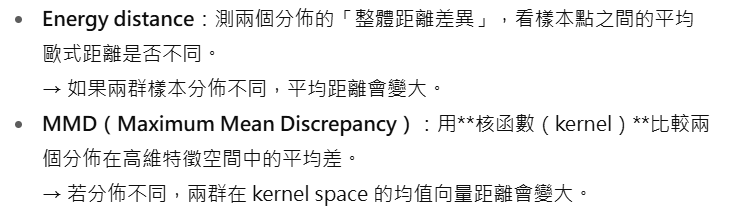